<a href="https://colab.research.google.com/github/meizano/ai/blob/main/7_Ghanaian_Dataset_Expert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dependencies**

In [ ]:
!pip install pyarrow

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split

import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import joblib

import pyarrow.feather as feather

# **Importing Data**

In [ ]:
# get authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
dm_data = pd.read_csv('/content/drive/MyDrive/Skripsi/Datasets/ghanaian_data.csv')

In [ ]:
# print the first 5 rows of the datasets
dm_data.head()

,AGE,Gender,FPG,HbA1c,Nocturia,Polyuria,Weight_loss,Vomiting,Nausea,Polydipsia,Polyphagia,Headache,BMI,Outcome
0,52,F,7.0,6.7,True,True,True,False,False,False,False,False,31.0,positive
1,57,M,10.8,8.0,False,False,False,False,False,False,False,False,32.0,positive
2,56,F,3.6,5.0,False,False,False,False,False,False,False,False,23.0,negative
3,32,F,7.5,6.8,False,False,False,False,False,False,False,False,31.0,positive
4,51,M,5.7,6.2,False,False,False,False,False,False,False,False,20.0,negative


# **Data Exploratory (Basic)**

In [ ]:
dm_data.shape

(3415, 14)

In [ ]:
dm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3415 entries, 0 to 3414
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          3415 non-null   int64  
 1   Gender       3414 non-null   object 
 2   FPG          3415 non-null   float64
 3   HbA1c        3415 non-null   float64
 4   Nocturia     3415 non-null   bool   
 5   Polyuria     3415 non-null   bool   
 6   Weight_loss  3415 non-null   bool   
 7   Vomiting     3415 non-null   bool   
 8   Nausea       3415 non-null   bool   
 9   Polydipsia   3415 non-null   bool   
 10  Polyphagia   3415 non-null   bool   
 11  Headache     3415 non-null   bool   
 12  BMI          3408 non-null   float64
 13  Outcome      3415 non-null   object 
dtypes: bool(8), float64(3), int64(1), object(2)
memory usage: 186.9+ KB


In [ ]:
dm_data.isnull().sum()

AGE            0
Gender         1
FPG            0
HbA1c          0
Nocturia       0
Polyuria       0
Weight_loss    0
Vomiting       0
Nausea         0
Polydipsia     0
Polyphagia     0
Headache       0
BMI            7
Outcome        0
dtype: int64

In [ ]:
# Unique Value Counts
unique_values = {}
for col in dm_data.columns:
    unique_values[col] = dm_data[col].value_counts().shape[0]

# Buat DataFrame dari dictionary unique_values
unique_values_df = pd.DataFrame(unique_values, index=['Unique Value Count']).transpose()

# Menggunakan format teks untuk mengatur tata letak teks pada kolom "Unique Value Count"
unique_values_df_styled = unique_values_df.style.format({'Unique Value Count': '<div style="text-align: center;">{}</div>'})

# Menggunakan format teks untuk mengatur tata letak teks pada nama kolom
unique_values_df_styled.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}], axis=1)

# Menampilkan DataFrame yang telah diatur tata letak teksnya
unique_values_df_styled

,Unique Value Count
AGE,55
Gender,2
FPG,99
HbA1c,87
Nocturia,2
Polyuria,2
Weight_loss,2
Vomiting,2
Nausea,2
Polydipsia,2


In [ ]:
zero_count = (dm_data == 0).sum()
print(zero_count)

AGE               0
Gender            0
FPG               0
HbA1c             0
Nocturia       1569
Polyuria       1569
Weight_loss    1569
Vomiting       3413
Nausea         3413
Polydipsia     3414
Polyphagia     3414
Headache       3413
BMI               1
Outcome           0
dtype: int64


In [ ]:
# check diabetes data distribution
dm_data['Outcome'].value_counts()

positive    2239
negative    1176
Name: Outcome, dtype: int64

# **Preprocessing**

## **Drop Missing Values**

In [ ]:
# Drop rows with missing values
dm_data_cleaned = dm_data.dropna()

# Reset index
dm_data = dm_data_cleaned.reset_index(drop=True)

In [ ]:
dm_data.isnull().sum()

AGE            0
Gender         0
FPG            0
HbA1c          0
Nocturia       0
Polyuria       0
Weight_loss    0
Vomiting       0
Nausea         0
Polydipsia     0
Polyphagia     0
Headache       0
BMI            0
Outcome        0
dtype: int64

In [ ]:
dm_data.drop(dm_data[dm_data['BMI'] == 0].index, inplace=True)

In [ ]:
zero_count = (dm_data == 0).sum()
print(zero_count)

AGE               0
Gender            0
FPG               0
HbA1c             0
Nocturia       1561
Polyuria       1561
Weight_loss    1561
Vomiting       3404
Nausea         3404
Polydipsia     3405
Polyphagia     3405
Headache       3404
BMI               0
Outcome           0
dtype: int64


In [ ]:
# check diabetes data distribution
dm_data['Outcome'].value_counts()

positive    2231
negative    1175
Name: Outcome, dtype: int64

## **Preprocessing -Data Transformation**

In [ ]:
dm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3406 entries, 0 to 3406
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          3406 non-null   int64  
 1   Gender       3406 non-null   object 
 2   FPG          3406 non-null   float64
 3   HbA1c        3406 non-null   float64
 4   Nocturia     3406 non-null   bool   
 5   Polyuria     3406 non-null   bool   
 6   Weight_loss  3406 non-null   bool   
 7   Vomiting     3406 non-null   bool   
 8   Nausea       3406 non-null   bool   
 9   Polydipsia   3406 non-null   bool   
 10  Polyphagia   3406 non-null   bool   
 11  Headache     3406 non-null   bool   
 12  BMI          3406 non-null   float64
 13  Outcome      3406 non-null   object 
dtypes: bool(8), float64(3), int64(1), object(2)
memory usage: 212.9+ KB


In [ ]:
dm_data.head()

,AGE,Gender,FPG,HbA1c,Nocturia,Polyuria,Weight_loss,Vomiting,Nausea,Polydipsia,Polyphagia,Headache,BMI,Outcome
0,52,F,7.0,6.7,True,True,True,False,False,False,False,False,31.0,positive
1,57,M,10.8,8.0,False,False,False,False,False,False,False,False,32.0,positive
2,56,F,3.6,5.0,False,False,False,False,False,False,False,False,23.0,negative
3,32,F,7.5,6.8,False,False,False,False,False,False,False,False,31.0,positive
4,51,M,5.7,6.2,False,False,False,False,False,False,False,False,20.0,negative


Label Encoding

In [ ]:
dm_data['Gender'] = dm_data['Gender'].replace({'F': 1, 'M': 0})

In [ ]:
dm_data['Outcome'] = dm_data['Outcome'].replace({'positive': 1, 'negative': 0})

In [ ]:
dm_data.head()

,AGE,Gender,FPG,HbA1c,Nocturia,Polyuria,Weight_loss,Vomiting,Nausea,Polydipsia,Polyphagia,Headache,BMI,Outcome
0,52,1,7.0,6.7,True,True,True,False,False,False,False,False,31.0,1
1,57,0,10.8,8.0,False,False,False,False,False,False,False,False,32.0,1
2,56,1,3.6,5.0,False,False,False,False,False,False,False,False,23.0,0
3,32,1,7.5,6.8,False,False,False,False,False,False,False,False,31.0,1
4,51,0,5.7,6.2,False,False,False,False,False,False,False,False,20.0,0


Booleans to Integer

In [ ]:
booleans = ['Nocturia', 'Polyuria', 'Weight_loss', 'Vomiting', 'Nausea', 'Polydipsia', 'Polyphagia', 'Headache']

In [ ]:
dm_data[booleans] = dm_data[booleans].astype(int)

In [ ]:
dm_data.head()

,AGE,Gender,FPG,HbA1c,Nocturia,Polyuria,Weight_loss,Vomiting,Nausea,Polydipsia,Polyphagia,Headache,BMI,Outcome
0,52,1,7.0,6.7,1,1,1,0,0,0,0,0,31.0,1
1,57,0,10.8,8.0,0,0,0,0,0,0,0,0,32.0,1
2,56,1,3.6,5.0,0,0,0,0,0,0,0,0,23.0,0
3,32,1,7.5,6.8,0,0,0,0,0,0,0,0,31.0,1
4,51,0,5.7,6.2,0,0,0,0,0,0,0,0,20.0,0


In [ ]:
dm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3406 entries, 0 to 3406
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          3406 non-null   int64  
 1   Gender       3406 non-null   int64  
 2   FPG          3406 non-null   float64
 3   HbA1c        3406 non-null   float64
 4   Nocturia     3406 non-null   int64  
 5   Polyuria     3406 non-null   int64  
 6   Weight_loss  3406 non-null   int64  
 7   Vomiting     3406 non-null   int64  
 8   Nausea       3406 non-null   int64  
 9   Polydipsia   3406 non-null   int64  
 10  Polyphagia   3406 non-null   int64  
 11  Headache     3406 non-null   int64  
 12  BMI          3406 non-null   float64
 13  Outcome      3406 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 399.1 KB


Convert to Category

In [ ]:
dm_data[['Gender', 'Outcome']] = dm_data[['Gender', 'Outcome']].astype('category')

In [ ]:
dm_data[booleans] = dm_data[booleans].astype('category')

In [ ]:
dm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3406 entries, 0 to 3406
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   AGE          3406 non-null   int64   
 1   Gender       3406 non-null   category
 2   FPG          3406 non-null   float64 
 3   HbA1c        3406 non-null   float64 
 4   Nocturia     3406 non-null   category
 5   Polyuria     3406 non-null   category
 6   Weight_loss  3406 non-null   category
 7   Vomiting     3406 non-null   category
 8   Nausea       3406 non-null   category
 9   Polydipsia   3406 non-null   category
 10  Polyphagia   3406 non-null   category
 11  Headache     3406 non-null   category
 12  BMI          3406 non-null   float64 
 13  Outcome      3406 non-null   category
dtypes: category(10), float64(3), int64(1)
memory usage: 167.5 KB


In [ ]:
for column in dm_data.columns:
    if dm_data[column].dtype.name != 'category':
        min_value = dm_data[column].min()
        max_value = dm_data[column].max()
        print(f"Column: {column}, Min: {min_value}, Max: {max_value}")

Column: AGE, Min: 5, Max: 209
Column: FPG, Min: 1.8, Max: 17.6
Column: HbA1c, Min: 2.3, Max: 14.0
Column: BMI, Min: 2.0, Max: 47.0


## **Save Data**

In [ ]:
#feather.write_feather(dm_data, '/content/drive/MyDrive/Skripsi/Datasets/ghanaian_data.feather')

# **All Features**

## **LightGBM**

In [ ]:
import lightgbm as lgb

In [ ]:
X = dm_data.drop('Outcome', axis=1)
y = dm_data['Outcome']

In [ ]:
all_start_time = time.time()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective = 'binary',
    metric = 'logloss'
)

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1761, number of negative: 963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 2724, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646476 -> initscore=0.603584
[LightGBM] [Info] Start training from score 0.603584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(metric='logloss', objective='binary')

In [ ]:
y_train_pred = lgb_model.predict(X_train)

In [ ]:
y_test_pred = lgb_model.predict(X_test)

In [ ]:
all_end_time = time.time()

# Calculate and print the hyperparameter tuning execution time
all_execution_time = all_end_time - all_start_time

if all_execution_time < 60:
    execution_time_string = f"{all_execution_time:.2f} seconds"
else:
    execution_time_string = f"{all_execution_time / 60:.2f} minutes"

print(f"Base Model with All Features Execution Time: {execution_time_string}")

Base Model with All Features Execution Time: 0.42 seconds


In [ ]:
print(lgb_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'logloss'}


## **Evaluation**

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

Training Model Performance

In [ ]:
print(classification_report(y_train, y_train_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       963
           1     1.0000    1.0000    1.0000      1761

    accuracy                         1.0000      2724
   macro avg     1.0000    1.0000    1.0000      2724
weighted avg     1.0000    1.0000    1.0000      2724



Test Model Performance

In [ ]:
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9769    0.9953    0.9860       212
           1     0.9979    0.9894    0.9936       470

    accuracy                         0.9912       682
   macro avg     0.9874    0.9923    0.9898       682
weighted avg     0.9913    0.9912    0.9912       682



### **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

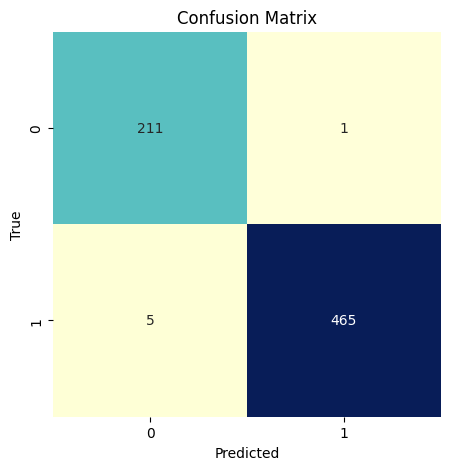

In [ ]:
# Calculate the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Iterate through each class
for i in range(matrix.shape[0]):
    # Print the class being processed
    print(f'Class {i}:')

    # Calculate TP (True Positive) for the current class
    TP = matrix[i, i]
    print(f'True Positive (TP) = [{i},{i}] = {TP}')

    # Calculate FP (False Positive) for the current class
    FP = sum(matrix[:, i]) - TP
    print(f'False Positive (FP) = (Sum of Column {i}) - TP = {FP}')

    # Calculate FN (False Negative) for the current class
    FN = sum(matrix[i, :]) - TP
    print(f'False Negative (FN) = (Sum of Row {i}) - TP = {FN}')

    # Calculate TN (True Negative) for the current class
    TN = matrix.sum() - (TP + FP + FN)
    print(f'True Negative (TN) = Total - (TP + FP + FN) = {TN}')

    # Add a line break for clarity
    print()


Class 0:
True Positive (TP) = [0,0] = 211
False Positive (FP) = (Sum of Column 0) - TP = 5
False Negative (FN) = (Sum of Row 0) - TP = 1
True Negative (TN) = Total - (TP + FP + FN) = 465

Class 1:
True Positive (TP) = [1,1] = 465
False Positive (FP) = (Sum of Column 1) - TP = 1
False Negative (FN) = (Sum of Row 1) - TP = 5
True Negative (TN) = Total - (TP + FP + FN) = 211



### **ROC AUC**

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Predict probability score
y_pred_prob = lgb_model.predict_proba(X_test)

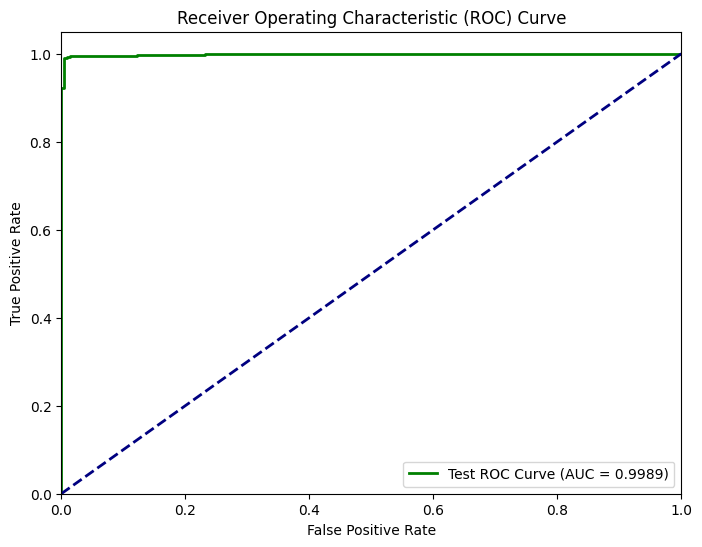

In [ ]:
# Predict probabilities for positive class (class 1) on training and testing sets
y_test_prob = lgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Selecting Features**

In [ ]:
dm_data = dm_data.loc[:, ['AGE', 'Nocturia', 'Polyuria', 'Weight_loss',
                          'Polydipsia', 'Polyphagia', 'BMI', 'Outcome']]

In [ ]:
#feather.write_feather(dm_data, '/content/drive/MyDrive/Skripsi/Datasets/7xp_ghanaian_data.feather')

In [ ]:
dm_data.head()

,AGE,Nocturia,Polyuria,Weight_loss,Polydipsia,Polyphagia,BMI,Outcome
0,52,1,1,1,0,0,31.0,1
1,57,0,0,0,0,0,32.0,1
2,56,0,0,0,0,0,23.0,0
3,32,0,0,0,0,0,31.0,1
4,51,0,0,0,0,0,20.0,0


In [ ]:
dm_data.shape

(3406, 8)

In [ ]:
dm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3406 entries, 0 to 3406
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   AGE          3406 non-null   int64   
 1   Nocturia     3406 non-null   category
 2   Polyuria     3406 non-null   category
 3   Weight_loss  3406 non-null   category
 4   Polydipsia   3406 non-null   category
 5   Polyphagia   3406 non-null   category
 6   BMI          3406 non-null   float64 
 7   Outcome      3406 non-null   category
dtypes: category(6), float64(1), int64(1)
memory usage: 100.5 KB


## **Model**

In [ ]:
X = dm_data.drop('Outcome', axis=1)
y = dm_data['Outcome']

In [ ]:
selected_start_time = time.time()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective = 'binary',
    metric = 'logloss',
)

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1761, number of negative: 963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 2724, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646476 -> initscore=0.603584
[LightGBM] [Info] Start training from score 0.603584


LGBMClassifier(metric='logloss', objective='binary')

In [ ]:
y_train_pred = lgb_model.predict(X_train)

In [ ]:
y_test_pred = lgb_model.predict(X_test)

In [ ]:
selected_end_time = time.time()

# Calculate and print the hyperparameter tuning execution time
selected_execution_time = selected_end_time - selected_start_time

if selected_execution_time < 60:
    execution_time_string = f"{selected_execution_time:.2f} seconds"
else:
    execution_time_string = f"{selected_execution_time / 60:.2f} minutes"

print(f"Model with Selected Features (Expert) Execution Time: {execution_time_string}")

Model with Selected Features (Expert) Execution Time: 0.38 seconds


## **Evaluation**

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

Training Model Performance

In [ ]:
print(classification_report(y_train, y_train_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9612    0.9522    0.9567       963
           1     0.9740    0.9790    0.9765      1761

    accuracy                         0.9695      2724
   macro avg     0.9676    0.9656    0.9666      2724
weighted avg     0.9695    0.9695    0.9695      2724



Test Model Performance

In [ ]:
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8969    0.9434    0.9195       212
           1     0.9739    0.9511    0.9623       470

    accuracy                         0.9487       682
   macro avg     0.9354    0.9472    0.9409       682
weighted avg     0.9499    0.9487    0.9490       682



### **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

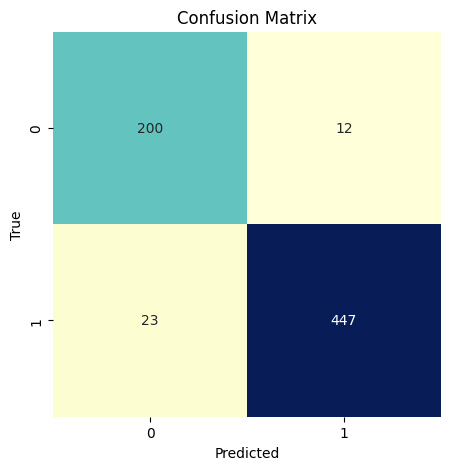

In [ ]:
# Calculate the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Iterate through each class
for i in range(matrix.shape[0]):
    # Print the class being processed
    print(f'Class {i}:')

    # Calculate TP (True Positive) for the current class
    TP = matrix[i, i]
    print(f'True Positive (TP) = [{i},{i}] = {TP}')

    # Calculate FP (False Positive) for the current class
    FP = sum(matrix[:, i]) - TP
    print(f'False Positive (FP) = (Sum of Column {i}) - TP = {FP}')

    # Calculate FN (False Negative) for the current class
    FN = sum(matrix[i, :]) - TP
    print(f'False Negative (FN) = (Sum of Row {i}) - TP = {FN}')

    # Calculate TN (True Negative) for the current class
    TN = matrix.sum() - (TP + FP + FN)
    print(f'True Negative (TN) = Total - (TP + FP + FN) = {TN}')

    # Add a line break for clarity
    print()


Class 0:
True Positive (TP) = [0,0] = 200
False Positive (FP) = (Sum of Column 0) - TP = 23
False Negative (FN) = (Sum of Row 0) - TP = 12
True Negative (TN) = Total - (TP + FP + FN) = 447

Class 1:
True Positive (TP) = [1,1] = 447
False Positive (FP) = (Sum of Column 1) - TP = 12
False Negative (FN) = (Sum of Row 1) - TP = 23
True Negative (TN) = Total - (TP + FP + FN) = 200



### **ROC AUC**

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Predict probability score
y_pred_prob = lgb_model.predict_proba(X_test)

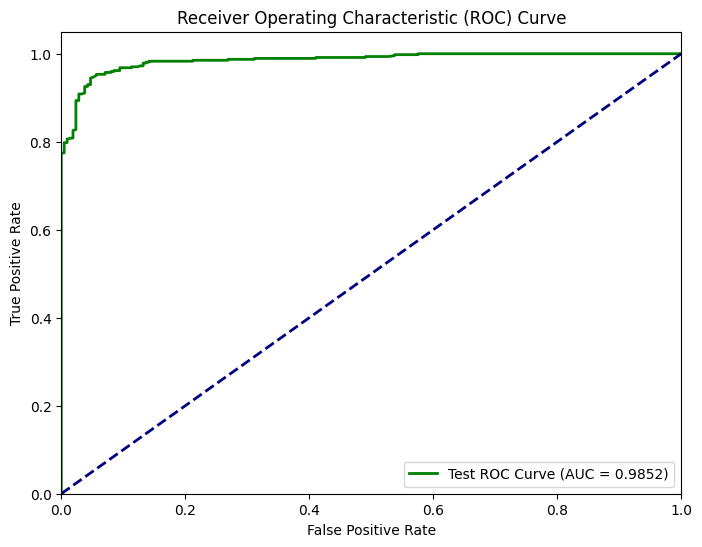

In [ ]:
# Predict probabilities for positive class (class 1) on training and testing sets
y_test_prob = lgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Save Model**

In [ ]:
#joblib.dump(lgb_model, '/content/drive/MyDrive/Skripsi/Model/model_xp.joblib')